In [152]:
import sys
sys.path.append('C:\\Users\\mohini\\Documents\\LoadModelingAndAgg\\pecan_street\\PecanPy\\examples')

import datetime as dat
from datetime import timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pecanpy
import scipy.stats as stats
import scipy as sp
import itertools
import numpy.random as random
from matplotlib.pyplot import cm

import configparser as cp

%matplotlib inline
plt.style.use("ggplot")

In [101]:
# Get access credentials
config = cp.ConfigParser();
config.read('setup.ini')

# define user credentials
USER_NAME = str(config['DEFAULT']['username']);
PASSWORD = str(config['DEFAULT']['password']);

# define db server params
SCHEMA = 'university'
HOST = 'dataport.cloud'
PORT = '5434'
DB = 'postgres'

# create the engine that connects to the database...
engine = pecanpy.create_engine(USER_NAME, PASSWORD, HOST, PORT, DB)

In [102]:
with engine.connect() as con:
    metadata_df = pecanpy.read_metadata_table(con, schema=SCHEMA)
[nHomes, nAttribs] = metadata_df.shape
print("Number of homes: " + str(nHomes))

Number of homes: 1460


In [4]:
with_egauge_data = metadata_df[metadata_df.egauge_min_time.notnull()]

In [5]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
with_times = metadata_df[metadata_df.egauge_min_time < start_time]
with_times = with_times[with_times.egauge_max_time > end_time]
print(with_times.shape)

(428, 108)


## Aggregate Analysis Functions
The following function computes different statistics for load data at different aggregation levels. It takes in a matrix of raw load data consisting of N homes with T load measurements. Then, based on the other arguments, these load profiles are sampled and aggregated to generate statistics of interest. 

In [150]:
def aggLoadStats(loadMat, aggLevels, statList, statArgs=None, samplesPerLevel=100):
# loadMat : [NxT] PANDAS Matrix of load measurements for N customers at T time points. 
# aggLevels: [A] Array of A aggregation levels. max(A) <= N
# statList: [length S list of functions]. Statistics to be computed on the aggregate load curves. 
# Every function in the list should take a (MxT) matrix argument where M is the number of chosen loads and
# a list of optional arguments. 
# samplesPerLevel: For N total customers and an aggregation level of k, we have
# N choose k possibilities. This might be too large a number to compute, so we limit
# the maximum number of aggregate samples we take at a given aggregation level. 
    [N, T] = np.shape(loadMat);
    
    # Some checks of the validity of args
    if max(aggLevels) > N:
        print("Warning: The highest level of aggregation is greater than available loads.")
    if (statArgs != None) and len(statList) != len(statArgs):
        print("Arguments given, but number of stats and number of args unequal.")
    
    nAggLevels = np.size(aggLevels);
    numStats = len(statList); 
    
    # Set up the matrix for gathering results. 
    loadStats = np.nan*np.ones([nAggLevels, samplesPerLevel, numStats]);
    
    for i in range(nAggLevels): 
        m = aggLevels[i];
        # Total number of possible combinations
        Nchoosem = int(sp.special.comb(N, m))
        
        if Nchoosem < samplesPerLevel:
            # Iterate through all possible combinations
            allCombs = itertools.combinations(np.arange(N), m)
            j = 0;
            for chosen in allCombs:
                chosen = np.array(chosen)
                chosenLoad = loadMat.iloc[chosen, :];
                # Compute and save all statistics
                for k in range(numStats):
                    statFunc = statList[k];
                    # Get arguments for this statistic
                    if statArgs == None:
                        argk = None;
                    else: 
                        argk = statArgs[k];
                    loadStats[i, j, k] = statFunc(chosenLoad, arg=argk);
                j = j + 1;
        else:
            # Generate "samplesPerLevel" of random combinations
            for j in range(samplesPerLevel):
                chosen = random.choice(N, size=m, replace=False);
                chosenLoad = loadMat.iloc[chosen, :]
                # Compute and save all statistics
                for k in range(numStats):
                    statFunc = statList[k];
                    # Get arguments for this statistic
                    if statArgs == None:
                        argk = None;
                    else:
                        argk = statArgs[k];
                    loadStats[i, j, k] = statFunc(chosenLoad, arg=argk);
                    
    return loadStats
    
###################################################################
# Statistics we wish to compute on aggregate load
# All these functions take an MxT matrix argument where 
# M = number of loads (some subset of all loads)
# T = number of measurement time points. 
###################################################################

def meanTotalLoad(load, arg=None):
    return np.mean(np.sum(load, axis=0));

def varTotalLoad(load, arg=None):
    return np.var(np.sum(load, axis=0));
                
def loadFactor(load, arg=None):
    totalLoad = np.sum(load, axis=0);
    maxLoad = np.max(totalLoad);
    meanLoad = np.mean(totalLoad);
    return meanLoad / maxLoad

def cvLoad(load, arg=None):
    totalLoad = np.sum(load, axis=0);
    meanLoad = np.mean(totalLoad);
    sigLoad = np.sqrt(np.var(totalLoad));
    return sigLoad / meanLoad

# This function aims to give us a sense of the predictability of the
# load as aggregation increases. 
def hourlyVar(load, arg=[12]):
    hour = arg[0];
    totalLoad = np.sum(load, axis=0);
    # Get time indices of total load
    times = pd.DatetimeIndex(totalLoad.index)
    # Get indices of measurements at the hour of interest
    hour_idx = (times.hour==hour);
    return np.var(totalLoad.iloc[hour_idx]);

# This function has the same aim as 'hourlyVar' but we normalize
# as so it is a coefficient of variation of load at a given hour
def hourlyCVLoad(load, arg=[12]):
    hour = arg[0];
    totalLoad = np.sum(load, axis=0);
    # Get time indices of total load
    times = pd.DatetimeIndex(totalLoad.index)
    # Get indices of measurements at the hour of interest
    hour_idx = (times.hour==hour);
    # Get load the hour
    hourLoad = totalLoad.iloc[hour_idx];
    hourMean = np.mean(hourLoad); hourSig = np.sqrt(np.var(hourLoad));
    return hourSig / hourMean

# This is a generalization of the load factor which uses a percentile
# rather than the maximum. 
def genLoadFactor(load, arg=[100]):
    percentile = arg[0];
    totalLoad = np.sum(load, axis=0);
    # Get the load at the percentile specified
    perLoad = np.percentile(totalLoad, percentile);
    meanLoad = np.mean(totalLoad);
    return meanLoad / perLoad

In [118]:
# This function is useful for dealing with the NaN values present in the
# output of the aggLoadStats function. This is useful for plotting the results
# without generating errors. 
def removeNans(data):
# data : [numSamples x numAggLevels] Matrix of statistics for numSamples at numAggLevels
# This function converts the 2D input data into a list of arrays where each array corresponds
# to a column in the input. NaNs are removed when converting columns to list elements. 
    mask = ~np.isnan(data)
    filtered_data = [d[m] for d, m in zip(data.T, mask.T)]
    return filtered_data;

# Experiment 1
## Variance of load over time vs. aggregation level

In [21]:
def getAggLoad(homes, start_time, end_time, rez='H'):
    dataCount = 0
    for home in homes:
        with engine.connect() as con:
            # Query data
            homeload = pecanpy.read_electricity_egauge_query(con, SCHEMA, home, start_time, end_time, "all", rez)
            load = homeload['use']
            bad = load.isnull().values.any() or load.empty
            if not bad:
                if dataCount==0:
                    totalLoad = load
                else:
                    totalLoad = totalLoad + load
                dataCount = dataCount + 1;
    return totalLoad, dataCount

def getNLoads(N, homes, start_time, end_time, rez='H'):
    dataCount = 0;
    idx = 0;
    numHomes = np.size(homes)
    while dataCount < N and idx < numHomes:
        with engine.connect() as con:
            home = homes[idx]
            homeload = pecanpy.read_electricity_egauge_query(con, SCHEMA, home, start_time, end_time, "all", rez)
            load = homeload['use']
            bad = load.isnull().values.any() or load.empty
            if not bad:
                if dataCount==0:
                    allLoads = load
                else:
                    allLoads = pd.concat([allLoads, load], axis=1)
                dataCount = dataCount + 1
            idx = idx + 1;
    return allLoads 

Text(0.5,1,'Aggregate load for 10 homes over 29 days.')

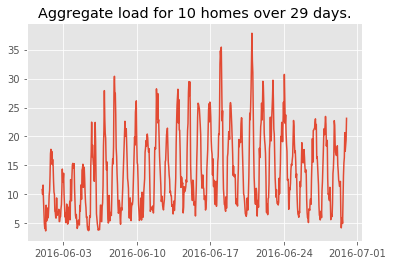

In [77]:
nAgg = 10
homes = with_times.sample(n=nAgg)
homes = homes.index

# Choose starting time and ending time
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
days = (end_time - start_time).days

# Get 1 hour resolution data for the homes
totalLoad, c = getAggLoad(homes, start_time, end_time)
plt.plot(totalLoad); plt.title('Aggregate load for ' + str(nAgg) + ' homes over ' + str(days) + ' days.')

In [135]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,2,0,0, tzinfo=timezone.utc)
N = 20; 

loads_20_df = getNLoads(N, with_times.index, start_time, end_time, rez='T')

In [23]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
N = 20; 

hourlyloads_20_df = getNLoads(N, with_times.index, start_time, end_time, rez='H')

<class 'pandas.core.frame.DataFrame'>
(696, 20)
DatetimeIndex(['2016-05-31 19:00:00-05:00', '2016-05-31 20:00:00-05:00',
               '2016-05-31 21:00:00-05:00', '2016-05-31 22:00:00-05:00',
               '2016-05-31 23:00:00-05:00', '2016-06-01 00:00:00-05:00',
               '2016-06-01 01:00:00-05:00', '2016-06-01 02:00:00-05:00',
               '2016-06-01 03:00:00-05:00', '2016-06-01 04:00:00-05:00',
               ...
               '2016-06-29 09:00:00-05:00', '2016-06-29 10:00:00-05:00',
               '2016-06-29 11:00:00-05:00', '2016-06-29 12:00:00-05:00',
               '2016-06-29 13:00:00-05:00', '2016-06-29 14:00:00-05:00',
               '2016-06-29 15:00:00-05:00', '2016-06-29 16:00:00-05:00',
               '2016-06-29 17:00:00-05:00', '2016-06-29 18:00:00-05:00'],
              dtype='datetime64[ns, US/Central]', name='localhour', length=696, freq='H')
Shape of hours
(29,)
<class 'pandas.core.series.Series'>
(696,)
(696,)
<class 'pandas.core.series.Series'>
Datet

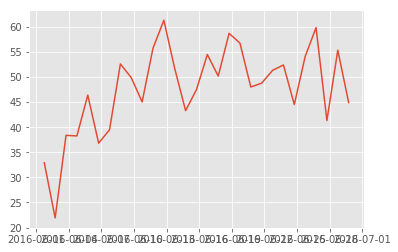

In [139]:
print(type(hourlyloads_20_df))
print(np.shape(hourlyloads_20_df))
H1 = hourlyloads_20_df.iloc[:, 0]
totalLoad = np.sum(hourlyloads_20_df.T, axis=0);
hourOfInterest = 13;

print(totalLoad.index)

times = pd.DatetimeIndex(totalLoad.index)
idx = times.hour==hourOfInterest;
data = totalLoad.iloc[idx];
print('Shape of hours')
print(np.shape(data))
plt.figure(); plt.plot(data)
print(type(totalLoad))
print(np.shape(totalLoad))
print(np.shape(H1))
print(type(H1))
print(H1.index)

## More extensive aggregate statistics tests
August 25, 2018

In [164]:
loadMat = hourlyloads_20_df.T;
aggLevels = np.arange(1, 16);
statList = [meanTotalLoad, varTotalLoad, loadFactor, cvLoad];
R = aggLoadStats(loadMat, aggLevels, statList, samplesPerLevel=1000)
# R has dimensions len(aggLevels) x samplesPerLevel x len(statList)

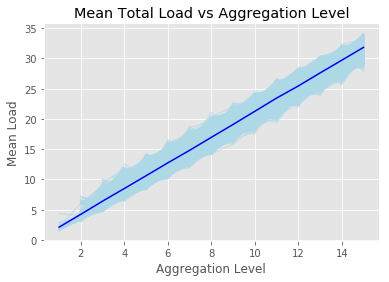

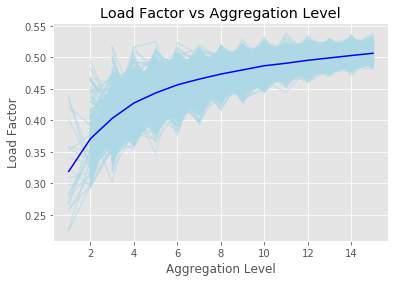

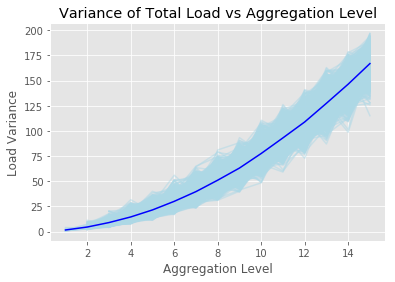

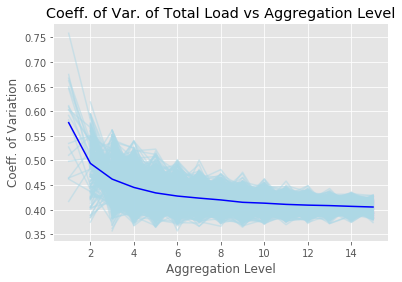

In [130]:
# Plot mean load vs aggregation
idx = 0;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Mean Load');
plt.title('Mean Total Load vs Aggregation Level');

# Plot load factor vs aggregation
idx = 2;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Load Factor');
plt.title('Load Factor vs Aggregation Level');

# Plot total variance of the load (over the full time series) vs aggregation
idx = 1;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue');
plt.xlabel('Aggregation Level'); plt.ylabel('Load Variance'); 
plt.title('Variance of Total Load vs Aggregation Level');

# Plot coeff of var of total load vs aggregation
idx = 3;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue');
plt.xlabel('Aggregation Level'); plt.ylabel('Coeff. of Variation'); 
plt.title('Coeff. of Var. of Total Load vs Aggregation Level');

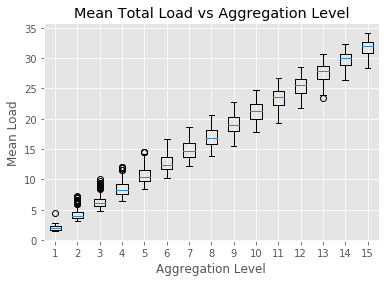

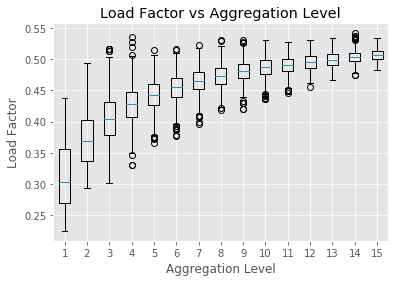

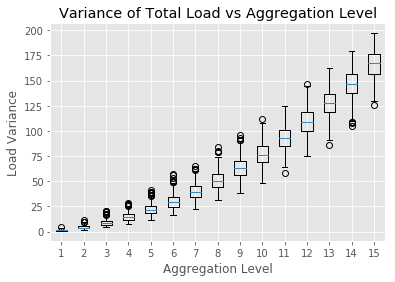

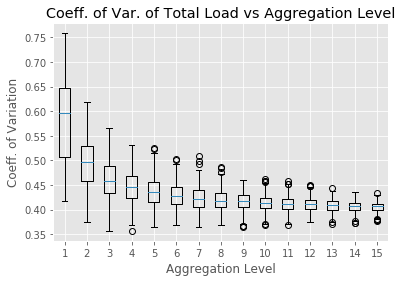

In [117]:
# BOX AND WHISKER plots of the above results. 
# Plot mean load vs aggregation
idx = 0;
plt.figure(); plt.boxplot(removeNans(R[:, :, idx].T));
plt.xlabel('Aggregation Level'); plt.ylabel('Mean Load');
plt.title('Mean Total Load vs Aggregation Level');

# Plot load factor vs aggregation
idx = 2;
plt.figure(); plt.boxplot(removeNans(R[:, :, idx].T));
plt.xlabel('Aggregation Level'); plt.ylabel('Load Factor');
plt.title('Load Factor vs Aggregation Level');

# Plot total variance of the load (over the full time series) vs aggregation
idx = 1;
plt.figure(); plt.boxplot(removeNans(R[:, :, idx].T));
plt.xlabel('Aggregation Level'); plt.ylabel('Load Variance'); 
plt.title('Variance of Total Load vs Aggregation Level');

# Plot coeff of var of total load vs aggregation
idx = 3;
plt.figure(); plt.boxplot(removeNans(R[:, :, idx].T));
plt.xlabel('Aggregation Level'); plt.ylabel('Coeff. of Variation'); 
plt.title('Coeff. of Var. of Total Load vs Aggregation Level');

In [148]:
loadMat = hourlyloads_20_df.T;
aggLevels = np.arange(1, 16);

hourVar = 13;
statList = [meanTotalLoad, hourlyVar, hourlyCVLoad];
statArgs = [[0], [hourVar], [hourVar]];
R = aggLoadStats(loadMat, aggLevels, statList, statArgs=statArgs, samplesPerLevel=1000)

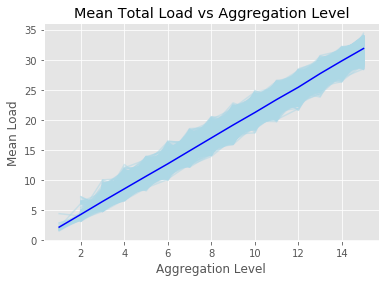

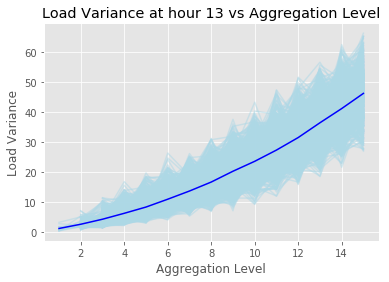

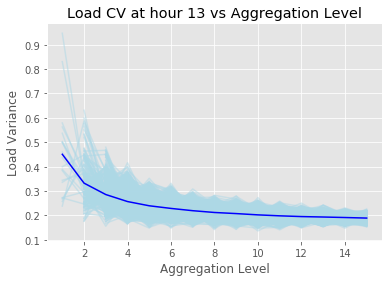

In [149]:
# Plot mean load vs aggregation
idx = 0;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Mean Load');
plt.title('Mean Total Load vs Aggregation Level');

# Plot variance at hour of interest
idx = 1;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Load Variance');
plt.title('Load Variance at hour ' + str(hourVar) + ' vs Aggregation Level');

# Plot variance at hour of interest
idx = 2;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Load Variance');
plt.title('Load CV at hour ' + str(hourVar) + ' vs Aggregation Level');

### Generalized Load Factor. 
Each line is the load factor for a particular percentile with the x-axis being the aggregation level. 

In [151]:
percentiles_array = np.arange(60, 100, 5)
statArgs = []
statList = []
for p in percentiles_array:
    statArgs.append([p]);
    statList.append(genLoadFactor)

loadMat = hourlyloads_20_df.T;
aggLevels = np.arange(1, 16);
R = aggLoadStats(loadMat, aggLevels, statList, statArgs=statArgs, samplesPerLevel=1000)

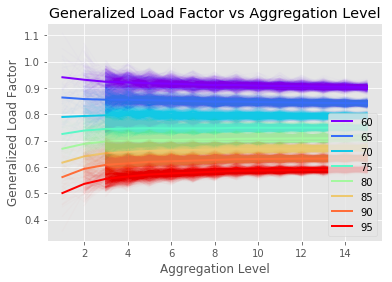

In [158]:
N = len(percentiles_array);
color=iter(cm.rainbow(np.linspace(0,1,N)))

plt.figure();
for idx in range(N):
    c=next(color)
    plt.plot(aggLevels, R[:, :, idx], color=c, alpha=0.01);
    plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color=c, label=str(percentiles_array[idx]), linewidth=2)

plt.xlabel('Aggregation Level'); plt.ylabel('Generalized Load Factor');
plt.title('Generalized Load Factor vs Aggregation Level'); plt.legend(loc='lower right');

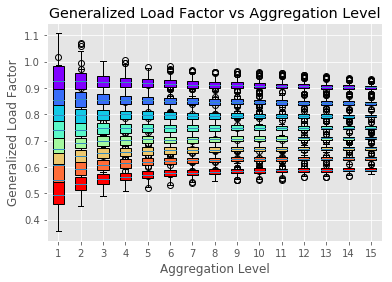

In [162]:
N = len(percentiles_array);
color=iter(cm.rainbow(np.linspace(0,1,N)))

plt.figure();
for idx in range(N):
    c=next(color)
    bplot = plt.boxplot(removeNans(R[:, :, idx].T), patch_artist=True);
    for patch in bplot['boxes']:
        patch.set_facecolor(c)c

plt.xlabel('Aggregation Level'); plt.ylabel('Generalized Load Factor');
plt.title('Generalized Load Factor vs Aggregation Level');

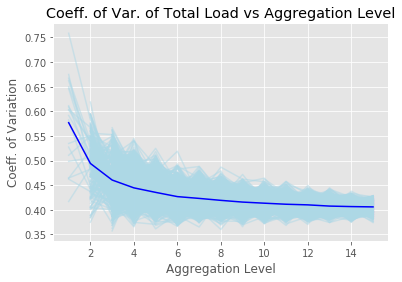

In [185]:
# Fit coeff of var
idx = 3;
RCV = R[:, :, idx];
plt.figure(); plt.plot(aggLevels, RCV, color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(RCV, axis=1), color='blue');
plt.xlabel('Aggregation Level'); plt.ylabel('Coeff. of Variation'); 
plt.title('Coeff. of Var. of Total Load vs Aggregation Level');

RCV = removeNans(RCV.T);

In [186]:
print(len(RCV))
print(np.shape(aggLevels))
N = len(RCV)
x = []; y = [];
for i in range(N):
    cvs = RCV[i];
    for el in cvs:
        y.append(el);
        x.append(aggLevels[i])
        
print(np.shape(x))
print(np.shape(y))
x = np.array(x); y = np.array(y);

x = 1.0 / x;
covxy = np.mean((x-np.mean(x))*(y-np.mean(y)));
varx = np.var(x);
C = covxy / varx;

b = np.mean(y-C*x)

15
(15,)
(13210,)
(13210,)


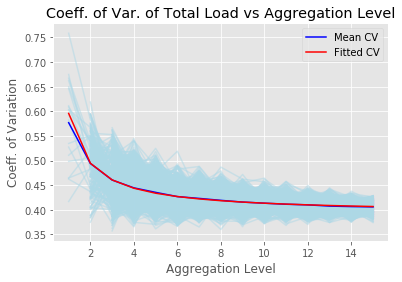

In [188]:
idx = 3;
RCV = R[:, :, idx];
plt.figure(); plt.plot(aggLevels, RCV, color='lightblue', alpha=0.5);
plt.plot(aggLevels, np.nanmean(RCV, axis=1), color='blue', label='Mean CV');
plt.xlabel('Aggregation Level'); plt.ylabel('Coeff. of Variation'); 
plt.title('Coeff. of Var. of Total Load vs Aggregation Level');
plt.plot(aggLevels, C*1.0/aggLevels + b, color='red', label='Fitted CV');
plt.legend(loc='upper right')

## To Do: 

1. Box and whisker plots of statistics. 
2. Generalized load factor. x-axis is percentile. Multiple lines for different aggregation levels. 